<a href="https://colab.research.google.com/github/Vishal1711/Deep-Learning-/blob/main/Traffic_Sign_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [260]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs/

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [261]:
ls german-traffic-signs

signnames.csv  test.p  train.p  valid.p


In [262]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Model
import random
import pickle
import pandas as pd

In [263]:
np.random.seed(0)

In [264]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  valid_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
print(X_test.shape)

(12630, 32, 32, 3)


In [265]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_valid.shape[0] == y_valid.shape[0]), "The number of images is not equal to the number of labels."

assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_valid.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

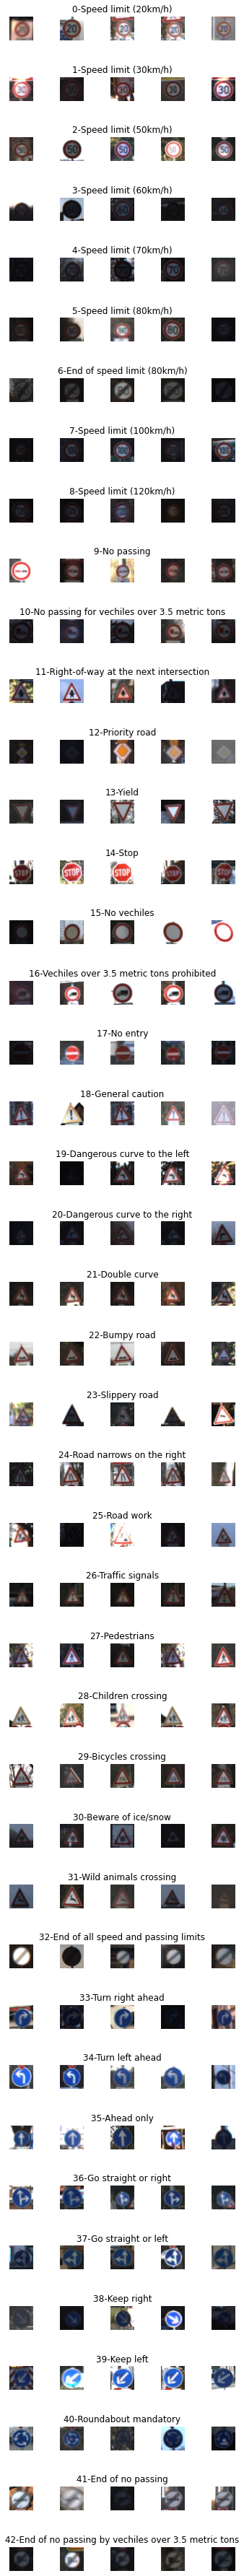

In [266]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i ==2:
          axs[j][i].set_title(str(j) + "-" + row["SignName"])
          num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of Images')

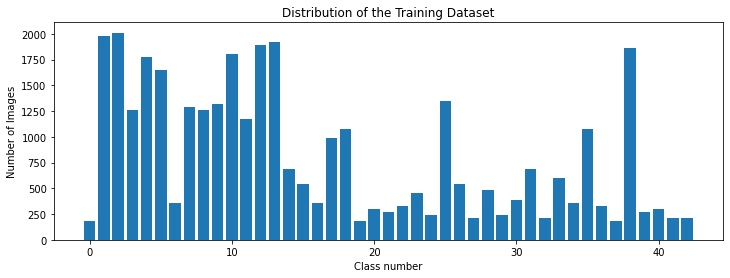

In [267]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the Training Dataset")
plt.xlabel("Class number")
plt.ylabel("Number of Images")

(32, 32, 3)
31


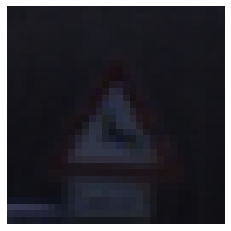

In [268]:
import cv2

plt.imshow(X_train[283])
plt.axis("off")
print(X_train[283].shape)
print(y_train[283])

(-0.5, 31.5, 31.5, -0.5)

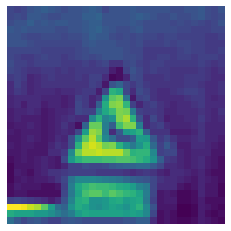

In [269]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[283])
plt.imshow(img)
plt.axis("off")

(32, 32)


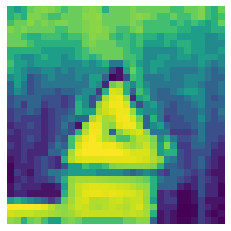

In [270]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

(34799, 32, 32)


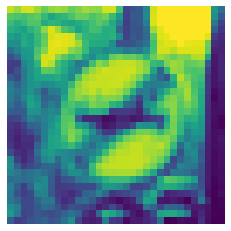

In [271]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_valid = np.array(list(map(preprocessing, X_valid )))
X_test = np.array(list(map(preprocessing, X_test)))
plt.imshow(X_train[random.randint(0,890)])
plt.axis("off")
print(X_train.shape)

In [272]:
X_train = X_train.reshape(34799,32,32,1)
X_valid = X_valid.reshape(4410,32,32,1)
X_test = X_test.reshape(12630,32,32,1)
print(X_train.shape)

(34799, 32, 32, 1)


**Data Augmentation**

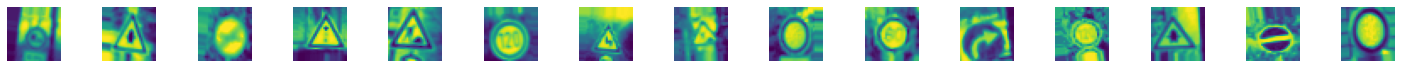

In [273]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)
# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

In [274]:
y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)
y_test = to_categorical(y_test, 43)

In [275]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape=(32,32,1),activation='relu'))
  model.add(Conv2D(60, (5,5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  model.add(Conv2D(30, (3,3), activation='relu'))
  model.add(Conv2D(30, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.001), 'categorical_crossentropy', metrics=['accuracy'])
  return model


In [276]:
model = modified_model()
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_39 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 12, 12, 60)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_41 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 4, 4, 30)         0         
 g2D)                                                

In [286]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch = len(X_train)//50, epochs=10, validation_data=(X_valid, y_valid), shuffle = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
695/695 [==============================] - 23s 33ms/step - loss: 0.5616 - accuracy: 0.8249 - val_loss: 0.1383 - val_accuracy: 0.9615
Epoch 2/10
695/695 [==============================] - 23s 33ms/step - loss: 0.3688 - accuracy: 0.8847 - val_loss: 0.1051 - val_accuracy: 0.9692
Epoch 3/10
695/695 [==============================] - 23s 34ms/step - loss: 0.2619 - accuracy: 0.9176 - val_loss: 0.0644 - val_accuracy: 0.9821
Epoch 4/10
695/695 [==============================] - 23s 34ms/step - loss: 0.2129 - accuracy: 0.9342 - val_loss: 0.0604 - val_accuracy: 0.9834
Epoch 5/10
695/695 [==============================] - 24s 34ms/step - loss: 0.1799 - accuracy: 0.9441 - val_loss: 0.0458 - val_accuracy: 0.9857
Epoch 6/10
695/695 [==============================] - 24s 34ms/step - loss: 0.1620 - accuracy: 0.9499 - val_loss: 0.0614 - val_accuracy: 0.9812
Epoch 7/10
695/695 [==============================] - 23s 33ms/step - loss: 0.1413 - accuracy: 0.9570 - val_loss: 0.0287 - val_accuracy:

Text(0.5, 0, 'epoch')

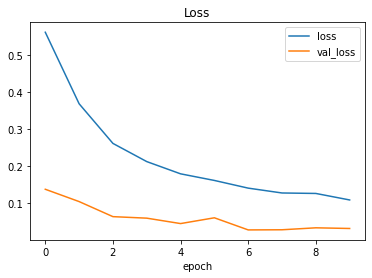

In [287]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

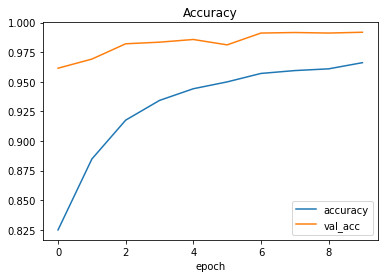

In [288]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [289]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test score:', score[0])
print('Test accuracy:', score[1])

<class 'list'>
Test score: 0.14268304407596588
Test accuracy: 0.966825008392334


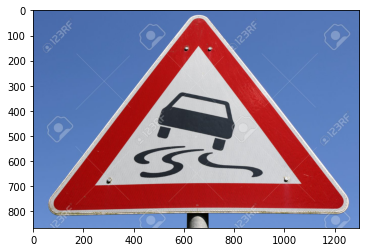

In [290]:
#fetch image
 
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


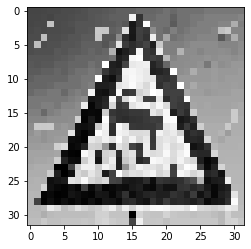

In [291]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [292]:
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
print("predicted sign: "+ str(np.argmax(model.predict(img), axis=-1)))

predicted sign: [23]
